In [ ]:
pip install opencv-python numpy


In [ ]:
!pip install opencv-python matplotlib numpy scikit-image


In [ ]:
!pip install timm --quiet


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import os
import matplotlib.pyplot as plt


In [ ]:
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
DATASET_ROOT = "/content/drive/MyDrive/silkworm"

train_data = datasets.ImageFolder(
    root=DATASET_ROOT,
    transform=train_transform
)

# Manual split using folder names
train_dir = os.path.join(DATASET_ROOT, "healthy/train")

train_dataset = datasets.ImageFolder(
    root=DATASET_ROOT,
    transform=train_transform
)

val_dataset = datasets.ImageFolder(
    root=DATASET_ROOT,
    transform=val_test_transform
)

test_dataset = datasets.ImageFolder(
    root=DATASET_ROOT,
    transform=val_test_transform
)

print("Classes:", train_dataset.classes)


Classes: ['diseased', 'healthy']


In [ ]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
def get_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = timm.create_model(
        "efficientnet_b0",
        pretrained=True,
        num_classes=2
    )
    return model.to(device), device

model, device = get_model()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.classifier.parameters(),
    lr=1e-3
)


In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {avg_loss:.4f} Val Acc: {val_acc:.2f}%")


Epoch [1/10] Loss: 1.9935 Val Acc: 61.90%
Epoch [2/10] Loss: 1.3825 Val Acc: 68.03%
Epoch [3/10] Loss: 1.0379 Val Acc: 74.15%
Epoch [4/10] Loss: 0.7944 Val Acc: 80.82%
Epoch [5/10] Loss: 0.6679 Val Acc: 84.49%
Epoch [6/10] Loss: 0.6076 Val Acc: 87.07%
Epoch [7/10] Loss: 0.4247 Val Acc: 88.03%
Epoch [8/10] Loss: 0.4296 Val Acc: 89.93%
Epoch [9/10] Loss: 0.3730 Val Acc: 91.70%
Epoch [10/10] Loss: 0.3449 Val Acc: 92.65%


In [ ]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 92.65%


In [ ]:
torch.save(model.state_dict(), "silkworm_efficientnet_b0.pth")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
#feature extraction from the efficient_netb0 model
import torch
import timm
from torchvision import transforms
from PIL import Image

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = timm.create_model(
    "efficientnet_b0",
    pretrained=False,
    num_classes=2
)

model.load_state_dict(torch.load("silkworm_efficientnet_b0.pth", map_location=device))
model = model.to(device)
model.eval()


EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [ ]:
IMG_SIZE = 224

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = test_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        probs = torch.softmax(outputs, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_class].item() * 100

    classes = ["Healthy", "Diseased"]
    return classes[pred_class], confidence


Prediction: diseased
Confidence: 99.88%


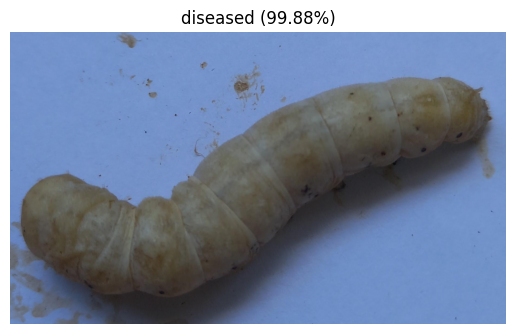

In [ ]:
#code upto classification between healthy and diseased
image_path = "/content/20220414_114206_jpg.rf.194c406a10aa3da420c0a259f7874642.jpg"  # change to your uploaded image name
label, confidence = predict_image(image_path)

print(f"Prediction: {label}")
print(f"Confidence: {confidence:.2f}%")
import matplotlib.pyplot as plt

img = Image.open(image_path)

plt.imshow(img)
plt.axis("off")
plt.title(f"{label} ({confidence:.2f}%)")
plt.show()



In [ ]:
print(train_dataset.class_to_idx)


{'diseased': 0, 'healthy': 1}


In [ ]:
class_names = train_dataset.classes
print(class_names)


['diseased', 'healthy']


In [ ]:
class_names = ['diseased', 'healthy']  # EXACT ORDER


In [ ]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = test_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        probs = torch.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_idx].item() * 100

    label = class_names[pred_idx]
    return label, confidence


In [ ]:
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=2)
model.load_state_dict(torch.load("silkworm_efficientnet_b0.pth", map_location=device))
model = model.to(device)
model.eval()

# Correct class order
class_names = ['diseased', 'healthy']


In [ ]:
IMG_SIZE = 224

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(
    root="/content/drive/MyDrive/silkworm",
    transform=test_transform
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        y_true.extend(labels.numpy())
        y_pred.extend(preds)


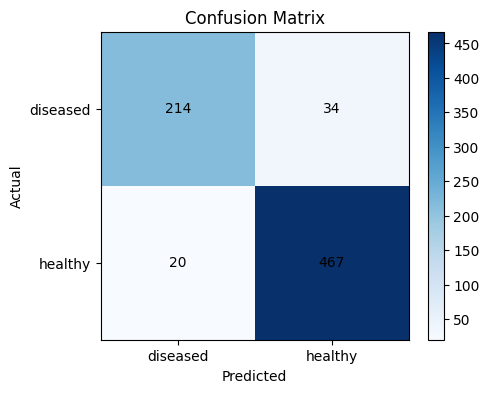

In [ ]:
#confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

plt.xticks([0,1], class_names)
plt.yticks([0,1], class_names)

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
#F1 score
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))


              precision    recall  f1-score   support

    diseased       0.91      0.86      0.89       248
     healthy       0.93      0.96      0.95       487

    accuracy                           0.93       735
   macro avg       0.92      0.91      0.92       735
weighted avg       0.93      0.93      0.93       735



In [ ]:
#GradCAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(input_tensor)
        output[0, class_idx].backward()

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = torch.relu(cam)
        cam = cam.squeeze().detach().cpu().numpy()   # ✅ FIXED
        cam = cv2.resize(cam, (224, 224))
        cam = cam / (cam.max() + 1e-8)

        return cam


In [ ]:
target_layer = model.conv_head
gradcam = GradCAM(model, target_layer)


In [ ]:
def run_gradcam(image_path):
    img = Image.open(image_path).convert("RGB")
    img_tensor = test_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        pred_class = torch.argmax(output, dim=1).item()

    cam = gradcam.generate(img_tensor, pred_class)

    img_np = np.array(img.resize((224,224)))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(10,4))

    plt.subplot(1,3,1)
    plt.imshow(img_np)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(heatmap)
    plt.title("Grad-CAM")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.title(f"Prediction: {class_names[pred_class]}")
    plt.axis("off")

    plt.show()


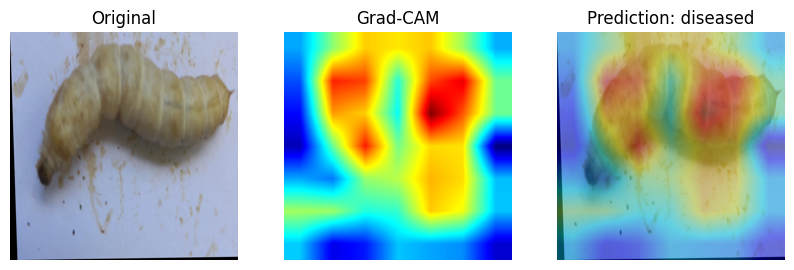

In [ ]:
run_gradcam("/content/drive/MyDrive/silkworm/diseased/train/20220414_114740_jpg.rf.4c8a5752440f15b887680a93c4e0f4dc.jpg")

In [ ]:
#pattern extractor,feature based

import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import os
import numpy as np


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.efficientnet_b0(pretrained=True)
model.classifier = torch.nn.Identity()   # 🔥 remove classifier
model = model.to(device)
model.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 57.4MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])


In [ ]:
def extract_features(image_path):
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        features = model(img)

    return features.squeeze().cpu().numpy()


In [ ]:
import os

image_dir = "/content/drive/MyDrive/silkworm"

features = []
image_names = []

for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(root, file)
            try:
                feat = extract_features(img_path)
                features.append(feat)
                image_names.append(img_path.replace(image_dir, ""))
            except Exception as e:
                print("Skipping:", img_path, e)


In [ ]:
import numpy as np
features = np.array(features)

print("Total images processed:", features.shape[0])
print("Feature dimension:", features.shape[1])


Total images processed: 735
Feature dimension: 1280


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
features_pca = pca.fit_transform(features)


In [ ]:
from sklearn.cluster import KMeans

k = 4   # try 3–6
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(features_pca)


In [ ]:
#Classificaton using clusters
for img, c in zip(image_names, clusters):
    print(img, "→ Cluster", c)


/healthy/train/20210321_121135_jpg.rf.7db02eb98c32248033a0081787b543c1.jpg → Cluster 2
/healthy/train/20210321_121327_jpg.rf.54bea0e7085f8f4d4e4902fc0d084ec7.jpg → Cluster 2
/healthy/train/20210321_121214_jpg.rf.450c7a742db8fcc1dacc94997aa097e0.jpg → Cluster 2
/healthy/train/20210321_121048_jpg.rf.861950cd7d9d6781e848e59ad8ffe9d2.jpg → Cluster 2
/healthy/train/20210321_121138_jpg.rf.1e1ce9ff4d07a7e41c967a8c4ad6f044.jpg → Cluster 2
/healthy/train/52_jpg.rf.f76e191894129fd3564bbb0814aa9b62.jpg → Cluster 1
/healthy/train/20210321_121422_jpg.rf.6ffdcc584ff3c90a6343f1a9e504ed6c.jpg → Cluster 2
/healthy/train/20210321_121126_jpg.rf.eaa7773239de864c7db5e8d666039478.jpg → Cluster 2
/healthy/train/20210321_121101_jpg.rf.104b1fda8d8d7daa6c753793ebc5be8c.jpg → Cluster 2
/healthy/train/20210321_121317_jpg.rf.3faa7a2963d4786ae2c509bb6b29abf4.jpg → Cluster 0
/healthy/train/20210321_121308_jpg.rf.3ec6d898a469e2c019b7f33a2e3ad6ba.jpg → Cluster 0
/healthy/train/20210321_121528_jpg.rf.67e68bb309d36e94d4

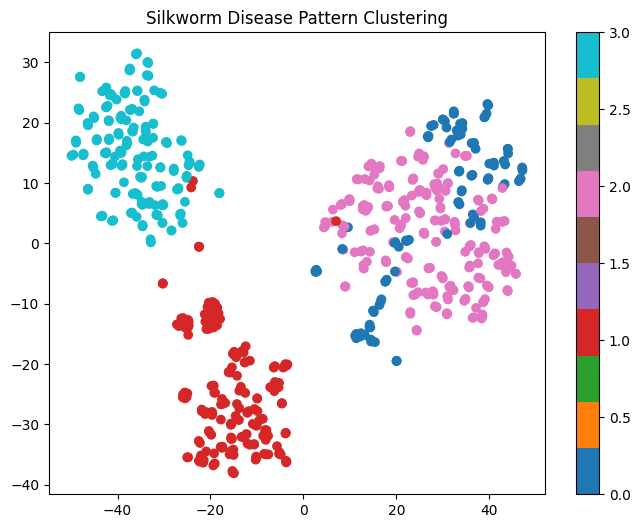

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features_pca)

plt.figure(figsize=(8,6))
plt.scatter(features_2d[:,0], features_2d[:,1], c=clusters, cmap='tab10')
plt.colorbar()
plt.title("Silkworm Disease Pattern Clustering")
plt.show()


In [ ]:
features = []
image_paths = []   # IMPORTANT: full paths

for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(root, file)
            try:
                feat = extract_features(img_path)
                features.append(feat)
                image_paths.append(img_path)   # FULL PATH
            except Exception as e:
                print("Skipping:", img_path, e)


In [ ]:
import numpy as np
features = np.array(features)

print("Total images processed:", features.shape[0])
print("Feature dimension:", features.shape[1])


Total images processed: 735
Feature dimension: 1280


In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components=50)
features_pca = pca.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features_pca)


In [ ]:
import shutil
import os

output_base = "/content/clusters"
os.makedirs(output_base, exist_ok=True)

for i, img_path in enumerate(image_paths):
    cluster_id = clusters[i]
    cluster_dir = os.path.join(output_base, f"cluster_{cluster_id}")
    os.makedirs(cluster_dir, exist_ok=True)

    shutil.copy(img_path, cluster_dir)

print("✅ Images successfully grouped into clusters")


✅ Images successfully grouped into clusters


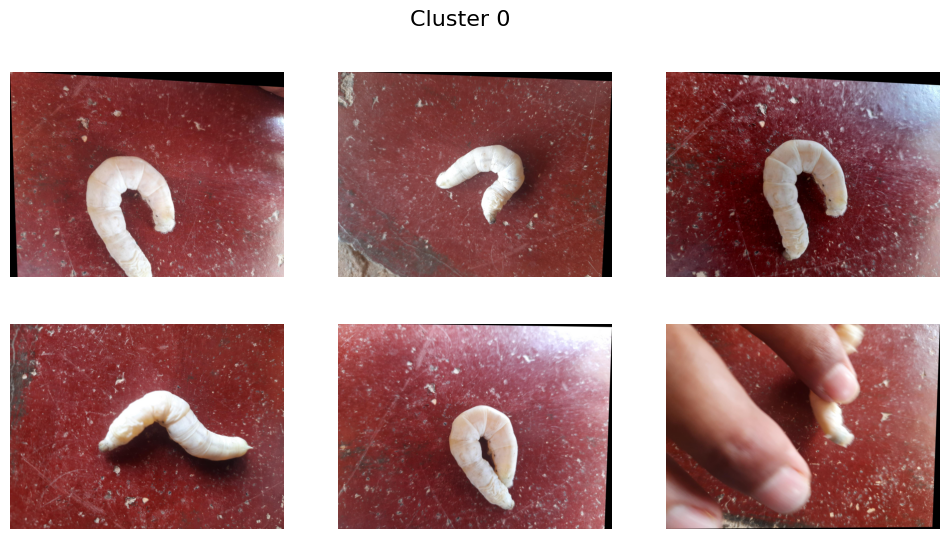

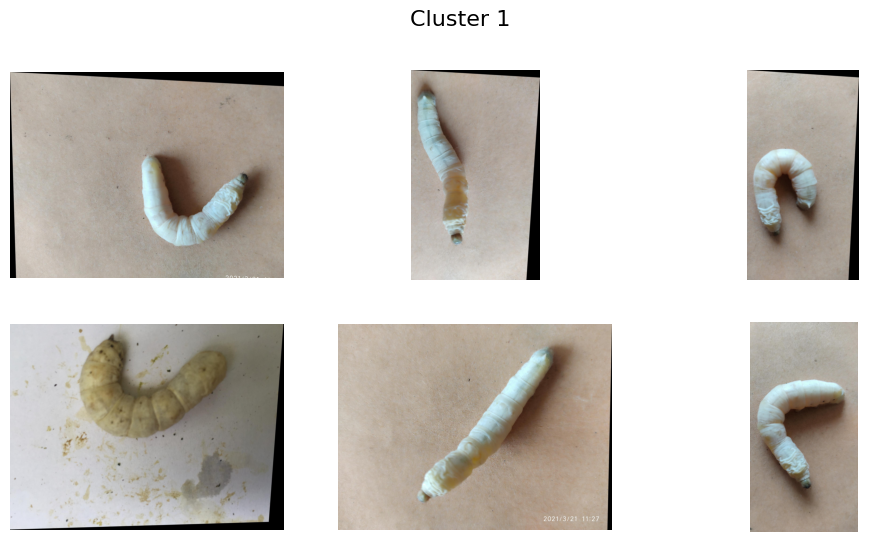

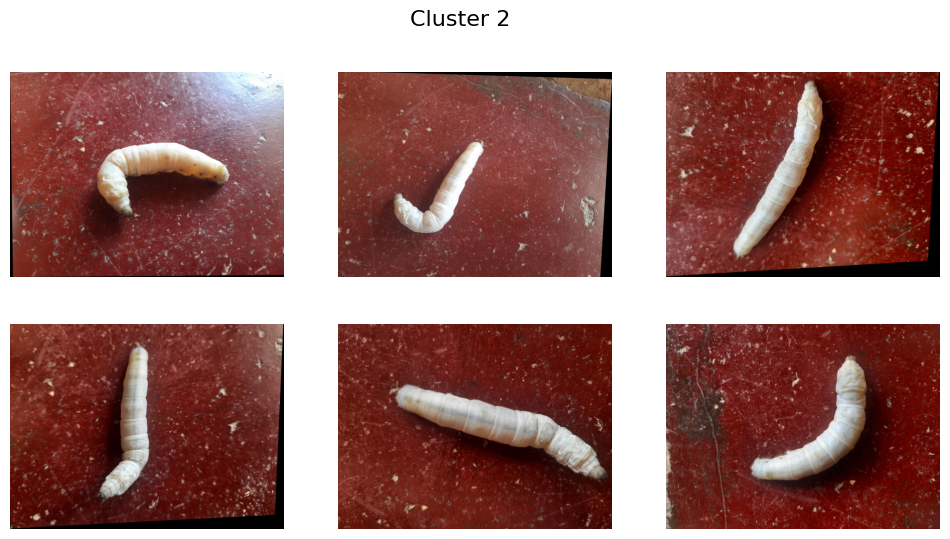

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_cluster_samples(cluster_id, num_images=6):
    cluster_path = f"/content/clusters/cluster_{cluster_id}"
    images = os.listdir(cluster_path)[:num_images]

    plt.figure(figsize=(12, 6))
    for i, img in enumerate(images):
        img_path = os.path.join(cluster_path, img)
        plt.subplot(2, 3, i+1)
        plt.imshow(Image.open(img_path))
        plt.axis("off")
    plt.suptitle(f"Cluster {cluster_id}", fontsize=16)
    plt.show()

for i in range(3):
    show_cluster_samples(i)


In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# ---- Image Transform ----
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ---- Grad-CAM Runner ----
def run_gradcam(image_path):
    model.eval()

    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    img_tensor.requires_grad = True

    output = model(img_tensor)
    pred_class = torch.argmax(output, dim=1).item()

    cam = gradcam.generate(img_tensor, pred_class)

    img_np = np.array(img.resize((224, 224)))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img_np)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM")
    plt.imshow(heatmap)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis("off")

    plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


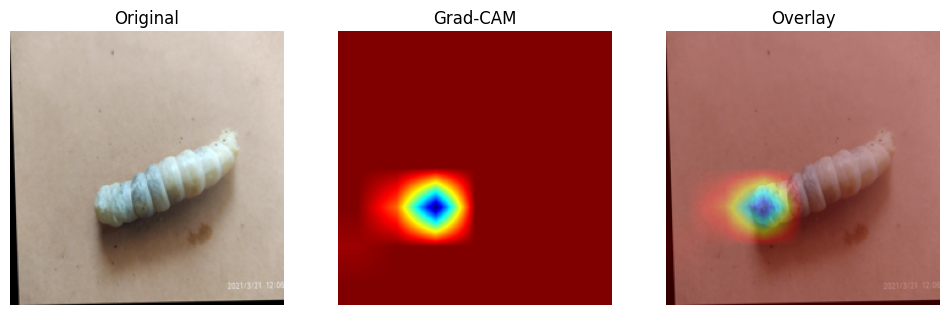

🖼 Image: /content/drive/MyDrive/silkworm/diseased/test/IMG_20210321_120622_jpg.rf.af2465f18bf0b98823975e56c60909bf.jpg
🔍 Health Status: Healthy
📊 Confidence: 99.85%
🧬 Disease Pattern: Pattern-A


NameError: name 'pattern_info' is not defined

In [ ]:

#1 Install dependencies
!pip install timm torch torchvision matplotlib pillow opencv-python scikit-learn --quiet

# 2 Import
import torch
import torch.nn as nn
import timm
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# 3Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4Load EfficientNet-B0 (binary classifier) using timm

num_classes = 2  # Healthy / Diseased
model = timm.create_model('efficientnet_b0', pretrained=False, num_classes=num_classes)
model = model.to(device)

# Load your trained checkpoint
checkpoint_path = "/silkworm_efficientnet_b0.pth"  # <-- change this
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint)
model.eval()

# 5️ Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self._forward_hook)
        self.target_layer.register_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(input_tensor)
        score = output[:, class_idx]
        score.backward()

        weights = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)
        cam = cam.squeeze().detach().cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = cam / (cam.max() + 1e-8)
        return cam

# For timm EfficientNet-B0, the last convolution is 'conv_head'
target_layer = model.conv_head
gradcam = GradCAM(model, target_layer)

# 6 Image transform
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

# 7️ Feature extractor for clustering

feature_extractor = nn.Sequential(
    model.conv_stem,
    *list(model.blocks.children()),
    model.conv_head,
    nn.AdaptiveAvgPool2d((1,1))
).to(device)
feature_extractor.eval()

# 8️ Build clustering on-the-fly from dataset
def build_cluster_model(dataset_folder, n_clusters=3):
    features_list = []

    for root, dirs, files in os.walk(dataset_folder):
        for file in files:
            if file.lower().endswith((".jpg",".jpeg",".png")):
                img_path = os.path.join(root, file)
                try:
                    img = Image.open(img_path).convert("RGB")
                    img_tensor = transform(img).unsqueeze(0).to(device)
                    with torch.no_grad():
                        feats = feature_extractor(img_tensor)
                        feats = feats.view(feats.size(0), -1).cpu().numpy()
                    features_list.append(feats[0])
                except:
                    continue

    features_array = np.array(features_list)
    pca = PCA(n_components=50)
    features_pca = pca.fit_transform(features_array)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_pca)

    return pca, kmeans

dataset_folder = "/content/drive/MyDrive/silkworm/"  # <-- point to full dataset (healthy + diseased)
pca, kmeans = build_cluster_model(dataset_folder, n_clusters=3)
pattern_map = {0:"Pattern-A", 1:"Pattern-B", 2:"Pattern-C"}


# 9 Prediction + Grad-CAM + Pattern recognition

pattern_meaning = {
    "Pattern-A": "Bacterial infection, mild",
    "Pattern-B": "Viral infection, moderate",
    "Pattern-C": "Fungal infection, severe"
}
def predict_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    # ---- Classification ----
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        conf, pred = torch.max(probs, dim=1)
    class_map = {0:"Healthy", 1:"Diseased"}
    predicted_class = class_map[pred.item()]
    confidence = conf.item()*100

    # ---- Pattern recognition ----
    with torch.no_grad():
        feats = feature_extractor(img_tensor)
        feats = feats.view(feats.size(0), -1).cpu().numpy()
    feats_pca = pca.transform(feats)
    cluster_id = kmeans.predict(feats_pca)[0]
    pattern = pattern_map.get(cluster_id, f"Cluster-{cluster_id}")

    # ---- Grad-CAM ----
    img_tensor.requires_grad = True
    cam = gradcam.generate(img_tensor, pred.item())
    img_np = np.array(img.resize((224,224)))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img_np); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(heatmap); plt.title("Grad-CAM"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
    plt.show()

    print(" Image:", image_path)
    print(" Health Status:", predicted_class)
    print(f" Confidence: {confidence:.2f}%")
    print("Disease Pattern:", pattern)

    return predicted_class, confidence, pattern

# 10️ Test on an example image
test_image = "/content/drive/MyDrive/silkworm/diseased/test/IMG_20210321_120622_jpg.rf.af2465f18bf0b98823975e56c60909bf.jpg"  # <-- change path
predict_image(test_image)


In [2]:

# 1️ Install dependencies

!pip install timm torch torchvision matplotlib pillow opencv-python scikit-learn --quiet

# 2️ Imports
import torch
import torch.nn as nn
import timm
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 3️ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4️ Load EfficientNet-B0

num_classes = 2  # Healthy / Diseased
model = timm.create_model(
    'efficientnet_b0',
    pretrained=False,
    num_classes=num_classes
).to(device)

checkpoint_path = "/silkworm_efficientnet_b0.pth"  # <-- change this
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint)
model.eval()

# 5️ Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, inp, out):
        self.activations = out

    def backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def generate(self, x, class_idx):
        model.zero_grad()
        out = model(x)
        out[:, class_idx].backward()

        weights = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)
        cam = cam.squeeze().detach().cpu().numpy()
        cam = cv2.resize(cam, (224,224))
        cam = cam / (cam.max() + 1e-8)
        return cam

gradcam = GradCAM(model, model.conv_head)

# 6️ Image Transform
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485,0.456,0.406],
        [0.229,0.224,0.225]
    )
])

# 7️ Feature Extractor

feature_extractor = nn.Sequential(
    model.conv_stem,
    *list(model.blocks.children()),
    model.conv_head,
    nn.AdaptiveAvgPool2d((1,1))
).to(device)
feature_extractor.eval()
-
# 8️ Build PCA + KMeans
def build_cluster_model(dataset_folder, n_clusters=3):
    features = []

    for root, _, files in os.walk(dataset_folder):
        for f in files:
            if f.lower().endswith((".jpg",".png",".jpeg")):
                try:
                    img = Image.open(os.path.join(root, f)).convert("RGB")
                    x = transform(img).unsqueeze(0).to(device)
                    with torch.no_grad():
                        feat = feature_extractor(x)
                        feat = feat.view(1,-1).cpu().numpy()
                    features.append(feat[0])
                except:
                    continue

    features = np.array(features)
    pca = PCA(n_components=50)
    features_pca = pca.fit_transform(features)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_pca)

    return pca, kmeans

dataset_folder = "/content/drive/MyDrive/silkworm/"  # <-- point to full dataset (healthy + diseased)
pca, kmeans = build_cluster_model(dataset_folder)

pattern_map = {0:"Pattern-A", 1:"Pattern-B", 2:"Pattern-C"}

# 9️ Pattern Meaning + Reason
pattern_details = {
    "Pattern-A": {
        "disease": "Bacterial Infection",
        "reason": "Localized texture distortions and slight discoloration detected by the CNN feature space."
    },
    "Pattern-B": {
        "disease": "Viral Infection",
        "reason": "Widespread structural irregularities and damage patterns."
    },
    "Pattern-C": {
        "disease": "Fungal Infection",
        "reason": "Dense contrast anomalies and affected regions indicating infection."
    }
}

# 10 Final Prediction Function

def predict_image(image_path):
    img = Image.open(image_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    # ---- Health Classification ----
    with torch.no_grad():
        out = model(x)
        probs = torch.softmax(out, dim=1)
        confidence, pred_class = torch.max(probs, dim=1)

    class_map = {0: "Diseased", 1: "Healthy"}
    health_status = class_map[pred_class.item()]
    confidence = confidence.item() * 100

    # ---- Always display health status and confidence ----
    print("🔍 Health Status :", health_status)
    print(f"📊 Confidence    : {confidence:.2f}%")


    #  CASE 1: HEALTHY → STOP HER
    if health_status == "Healthy":
        print("✅ No disease detection required for healthy silkworm.")

        plt.figure(figsize=(4,4))
        plt.imshow(img)
        plt.title("Healthy Silkworm")
        plt.axis("off")
        plt.show()

        return health_status, confidence, None


    # ❌ CASE 2: DISEASED → CONTINUE


    # ---- Pattern Recognition ----
    with torch.no_grad():
        feat = feature_extractor(x)
        feat = feat.view(1, -1).cpu().numpy()

    feat_pca = pca.transform(feat)
    cluster_id = kmeans.predict(feat_pca)[0]
    pattern = pattern_map[cluster_id]
    info = pattern_details[pattern]

    # ---- Grad-CAM ----
    x.requires_grad = True
    cam = gradcam.generate(x, pred_class.item())

    img_np = np.array(img.resize((224,224)))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # ---- Display ----
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img_np); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(heatmap); plt.title("Grad-CAM"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Affected Regions"); plt.axis("off")
    plt.show()

    # ---- Text Output ----
    print("🧬 Disease Pattern :", pattern)
    print("🦠 Likely Disease  :", info["disease"])
    print("🧠 Reason          :", info["reason"])

    return health_status, confidence, pattern

# 11️ Test Example

test_image = "/content/drive/MyDrive/silkworm/diseased/val/IMG_2257_JPG.rf.75e297b3f7f177fb96f32372587331c6.jpg"  # <-- change path
predict_image(test_image)


SyntaxError: invalid syntax (ipython-input-1692584987.py, line 83)

🔍 Health Status : Diseased
📊 Confidence    : 98.18%


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


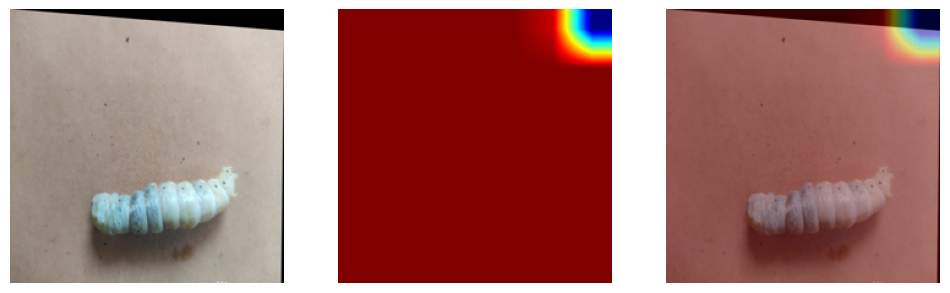

🧬 Disease Pattern : Pattern-A
🦠 Likely Disease  : Bacterial Infection
🧠 Reason          : Localized texture distortions and slight discoloration detected by the CNN feature space.


('Diseased', 98.18368554115295, 'Pattern-A')

In [6]:
# 1️ Install dependencies
!pip install timm torch torchvision matplotlib pillow opencv-python scikit-learn --quiet

# 2️ Imports
import torch
import torch.nn as nn
import timm
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 3️ Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4️ Load EfficientNet-B0
num_classes = 2  # Healthy / Diseased
model = timm.create_model(
    'efficientnet_b0',
    pretrained=False,
    num_classes=num_classes
).to(device)

checkpoint_path = "/silkworm_efficientnet_b0.pth"  # <-- change this
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint)
model.eval()

# 5️ Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, inp, out):
        self.activations = out

    def backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def generate(self, x, class_idx):
        model.zero_grad()
        out = model(x)
        out[:, class_idx].backward()

        weights = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)
        cam = cam.squeeze().detach().cpu().numpy()
        cam = cv2.resize(cam, (224,224))
        cam = cam / (cam.max() + 1e-8)
        return cam

gradcam = GradCAM(model, model.conv_head)

# 6️ Image Transform
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485,0.456,0.406],
        [0.229,0.224,0.225]
    )
])

# 7️ Feature Extractor
feature_extractor = nn.Sequential(
    model.conv_stem,
    *list(model.blocks.children()),
    model.conv_head,
    nn.AdaptiveAvgPool2d((1,1))
).to(device)
feature_extractor.eval()

# 8️ Build PCA + KMeans
def build_cluster_model(dataset_folder, n_clusters=3):
    features = []

    for root, _, files in os.walk(dataset_folder):
        for f in files:
            if f.lower().endswith((".jpg",".png",".jpeg")):
                try:
                    img = Image.open(os.path.join(root, f)).convert("RGB")
                    x = transform(img).unsqueeze(0).to(device)
                    with torch.no_grad():
                        feat = feature_extractor(x)
                        feat = feat.view(1,-1).cpu().numpy()
                    features.append(feat[0])
                except:
                    continue

    features = np.array(features)
    pca = PCA(n_components=50)
    features_pca = pca.fit_transform(features)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_pca)

    return pca, kmeans

dataset_folder = "/content/drive/MyDrive/silkworm/"
pca, kmeans = build_cluster_model(dataset_folder)

pattern_map = {0:"Pattern-A", 1:"Pattern-B", 2:"Pattern-C"}

# 9️ Pattern Meaning + Reason
pattern_details = {
    "Pattern-A": {
        "disease": "Bacterial Infection",
        "reason": "Localized texture distortions and slight discoloration detected by the CNN feature space."
    },
    "Pattern-B": {
        "disease": "Viral Infection",
        "reason": "Widespread structural irregularities and damage patterns."
    },
    "Pattern-C": {
        "disease": "Fungal Infection",
        "reason": "Dense contrast anomalies and affected regions indicating infection."
    }
}

# 10️ Final Prediction Function
def predict_image(image_path):
    img = Image.open(image_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(x)
        probs = torch.softmax(out, dim=1)
        confidence, pred_class = torch.max(probs, dim=1)

    class_map = {0: "Diseased", 1: "Healthy"}
    health_status = class_map[pred_class.item()]
    confidence = confidence.item() * 100

    print("🔍 Health Status :", health_status)
    print(f"📊 Confidence    : {confidence:.2f}%")

    if health_status == "Healthy":
        print("✅ No disease detection required for healthy silkworm.")
        plt.imshow(img)
        plt.axis("off")
        plt.show()
        return health_status, confidence, None

    with torch.no_grad():
        feat = feature_extractor(x)
        feat = feat.view(1, -1).cpu().numpy()

    feat_pca = pca.transform(feat)
    cluster_id = kmeans.predict(feat_pca)[0]
    pattern = pattern_map[cluster_id]
    info = pattern_details[pattern]

    x.requires_grad = True
    cam = gradcam.generate(x, pred_class.item())

    img_np = np.array(img.resize((224,224)))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img_np); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(heatmap); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.axis("off")
    plt.show()

    print("🧬 Disease Pattern :", pattern)
    print("🦠 Likely Disease  :", info["disease"])
    print("🧠 Reason          :", info["reason"])

    return health_status, confidence, pattern

# 11️ Test Example
test_image = "/content/drive/MyDrive/silkworm/diseased/val/IMG_20210321_120629_jpg.rf.3064984dd41ef3eef28d6e7a1c2cbcf4.jpg"
predict_image(test_image)
